# Import libraries 

In [3]:
import json
import math
import affine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

# Print metadata

In [1]:
# This Python script reads a file and extracts metadata keys from it. 

# 2019:
# with open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img.hdr","r") as f:
#    print("Metadata keys:\n"+", ".join(
#        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

# # 2017:
# with open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20170809t232252\\ang20170809t232252_rdn_v2p9\\ang20170809t232252_rdn_v2p9_img.hdr","r") as f:
#     print("Metadata keys:\n"+", ".join(
#         [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

# 2022:
with open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20220812t220245\\ang20220812t220245_rdn_v2aa2\\ang20220812t220245_rdn_v2aa2_img.hdr","r") as f:
    print("Metadata keys:\n"+", ".join(
        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))


Metadata keys:
description, samples, lines, bands, header offset, file type, data type, interleave, byte order, map info, radiance version, bad pixel map, flat field file, rcc file, spectral scatter file, wavelength file, crosstrack scatter file, wavelength, fwhm, wavelength units, smoothing factors, data ignore value


# Open image as img

In [4]:
# # open the ENVI file
#img = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img") # 2019
#img = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20170809t232252\\ang20170809t232252_rdn_v2p9\\ang20170809t232252_rdn_v2p9_img") # 2017
img = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20220812t220245\\ang20220812t220245_rdn_v2aa2\\ang20220812t220245_rdn_v2aa2_img") # 2022

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))


Bands:	425
Rows:	8136
Cols:	677


C:\Users\smdur\anaconda3\envs\ABOVE\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Observe Bands 

In [5]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands

#bands.to_csv('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\bands.txt', sep='\t', index=False)


Band number  Band center (nm)           EM region
1              1        377.195650      visible-violet
2              2        382.205650      visible-violet
3              3        387.215649      visible-violet
4              4        392.225649      visible-violet
5              5        397.225649      visible-violet
..           ...               ...                 ...
421          421       2480.835649  shortwave-infrared
422          422       2485.845650  shortwave-infrared
423          423       2490.855649  shortwave-infrared
424          424       2495.865649  shortwave-infrared
425          425       2500.875650                None

[425 rows x 3 columns]

# Plot Sites within imagery

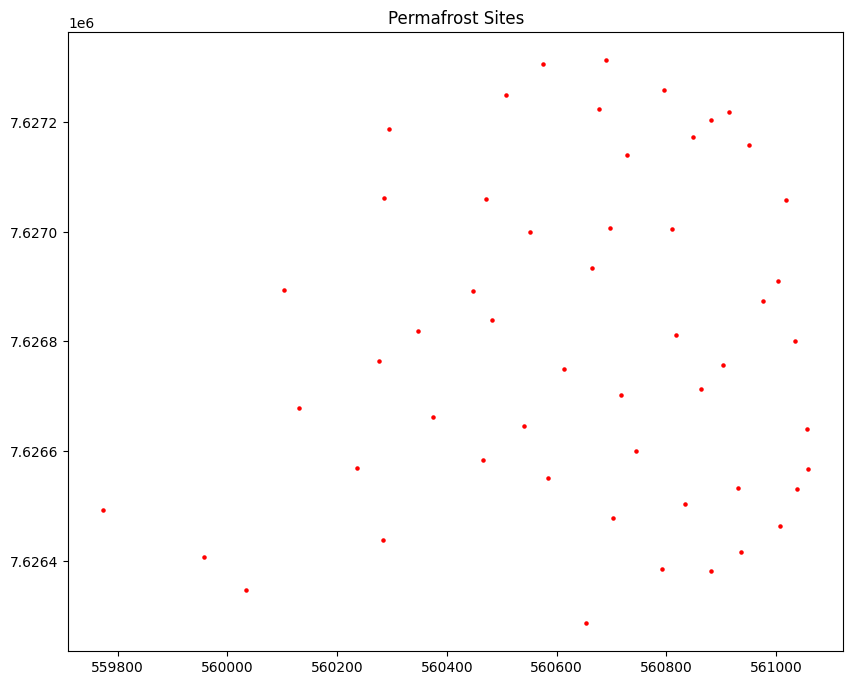

In [6]:
#
#sites = "D:\\ABoVE\\Shapefile\\TL_Permafrost_Monitoring.shp"
sites = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_pt.shp"

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
permafrost_sites = driver.Open(sites, 0)

# get the first feature in the shapefile as JSON
site1 = json.loads(permafrost_sites[0].GetFeature(0).ExportToJson())
site1

import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
sites = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_pt.shp"
sites_gdf = gpd.read_file(sites)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the figure size as needed
sites_gdf.plot(ax=ax, marker='o', color='red', markersize=5)  # Plot points with red circle markers
ax.set_title('Permafrost Sites')
plt.show()


# from tutorial - not needed 

In [13]:
# from osgeo import ogr, osr
# import affine
# # shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
# lyr = permafrost_sites.GetLayer() # get the only layer in the shapefile
# feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
# geom = feat.GetGeometryRef()      # get the feature's geometry

# # get transform for decimal degrees
# from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
# to_srs = osr.SpatialReference()                                        # init ogr srs object
# to_srs.ImportFromEPSG(4326)                                            # import wgs84 srs def
# xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object
# #xytransform = osr.CoordinateTransformation(to_srs)            # get transform object

# # get UTM and lat/long coordinates for each of the sites
# utm_coordinate_pairs = {}
# ll_coordinate_pairs = {}
# for feature in lyr:
#     geom = feature.GetGeometryRef()                                    # get site geometry
#     utm_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
#     geom.Transform(xytransform)                                        # to wgs84
#     ll_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY())  # get lon, lat
    
# # # get the x and y UTM coordinates for the first site
# # #x, y = utm_coordinate_pairs['TL_IS_2']
# # x, y = utm_coordinate_pairs['1']
# # #x, y = utm_coordinate_pairs['Alder']

# # affine_transform = affine.Affine.from_gdal(*img.GetGeoTransform())     # affine forward transform
# # inverse_transform = ~affine_transform                                  # invert transform
# # px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
# # px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers

# # # print the three coordinates (UTM, geographic, image)
# # print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
# #        " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['1']),
# #        " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

In [ ]:
# # get image coordinates for each site
# image_coordinate_pairs = {
#     site: inverse_transform * pair for site,pair in utm_coordinate_pairs.items()}

# print("site id: (col, row)")
# for site,coord in image_coordinate_pairs.items():  # must convert to int to raster array  
#     print(site + ": (" + str(int(coord[0] + 0.5)) + ", " + str(int(coord[1] + 0.5)) +")")

In [ ]:
# site1name = list(image_coordinate_pairs.keys())[0]    # get name of site1
# site1xy = list(image_coordinate_pairs.values())[0]    # get image coordinates of site1
# px, py = int(site1xy[0] + 0.5), int(site1xy[1] + 0.5) # convert image coordinates to integers

# band1_array = img.GetRasterBand(1).ReadAsArray()
# print("Band 1 reflectance at site 1: "+str(band1_array[py,px]))

In [ ]:
# # function gets value at input xy from input band
# get_pixel = lambda img,band,y,x: img.GetRasterBand(band).ReadAsArray()[y,x]

# # make a copy of the bands data frame and add reflectance column for site 1
# _bands = bands
# _bands[site1name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
# _bands.head(10)

In [ ]:
# site2name = list(image_coordinate_pairs.keys())[1]    # get name of site1
# site2xy = list(image_coordinate_pairs.values())[1]    # get image coordinates of site1
# px, py = int(site2xy[0] + 0.5), int(site2xy[1] + 0.5) # convert image coordinates to int

# _bands[site2name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
# _bands.head(10)

In [ ]:
# from tqdm import tqdm  # Import tqdm

# # Read all bands data at once
# band_data = [img.GetRasterBand(b).ReadAsArray() for b in range(1, nbands+1)]

# # Now you can access the pixel value directly from the array in memory without reading from file
# get_pixel = lambda band_data, b, y, x: band_data[b-1][y, x]

# # Assuming 'bands' is a DataFrame and you want to add a new column for reflectance
# # You can now use the get_pixel function with pre-loaded band_data
# # Wrap range(1, nbands+1) with tqdm for a progress bar
# bands[site1name + " reflectance"] = [get_pixel(band_data, b, py, px) for b in tqdm(range(1, nbands+1), desc="Processing bands")]


# Visualize data

In [7]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                  59
Band center (nm)      667.69565
EM region           visible-red
Name: 59, dtype: object
------------------------------------------------------------
Band number                    34
Band center (nm)        542.48565
EM region           visible-green
Name: 34, dtype: object
------------------------------------------------------------
Band number                   20
Band center (nm)      472.355649
EM region           visible-blue
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (8136, 677, 3)


In [8]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

print("the first 10 x coordinates:")
xarr[:10]

the first 10 x coordinates:


array([561400, 561405, 561409, 561414, 561419, 561424, 561429, 561434,
       561438, 561443])

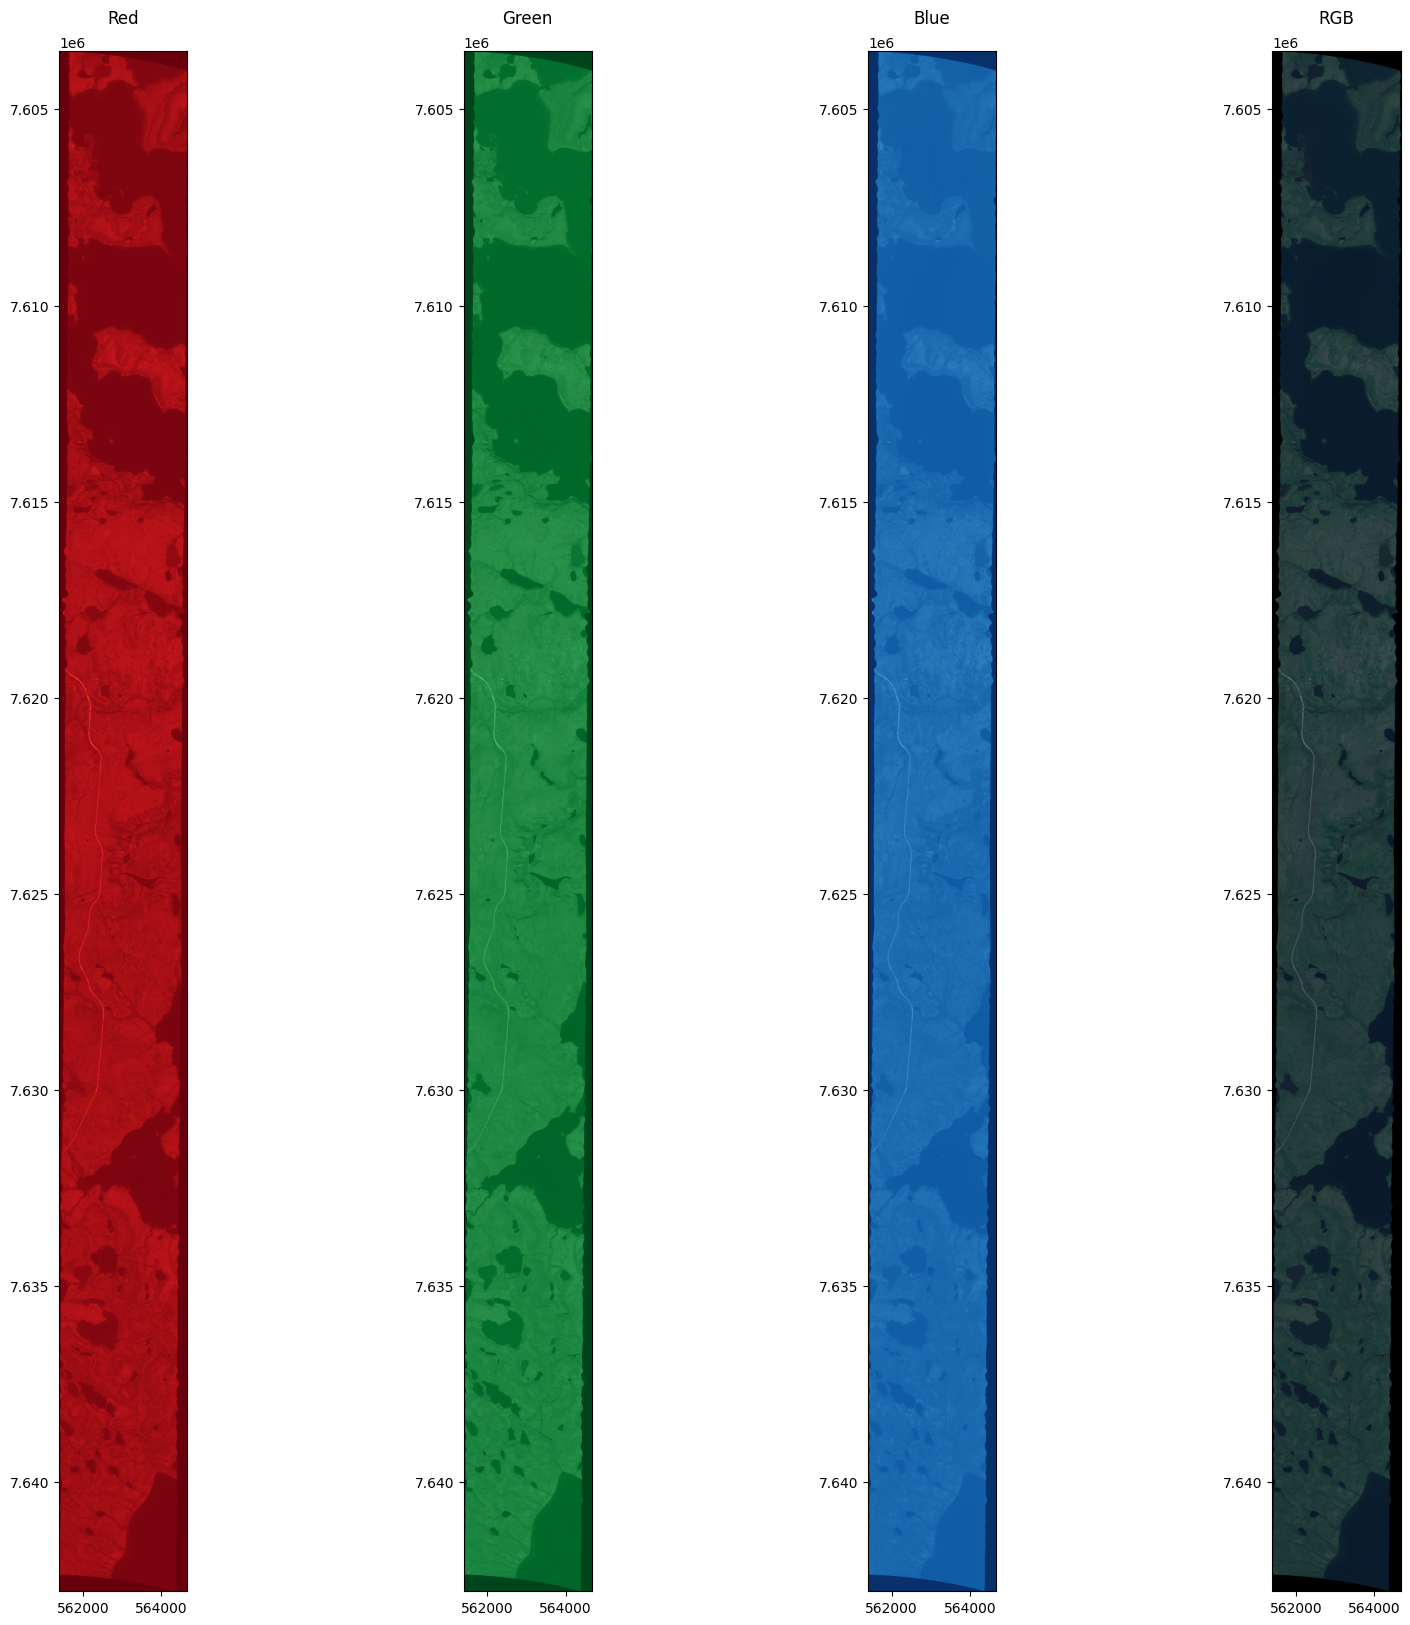

In [9]:
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)  
    

   
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite.png", dpi=300, bbox_inches='tight')


plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])

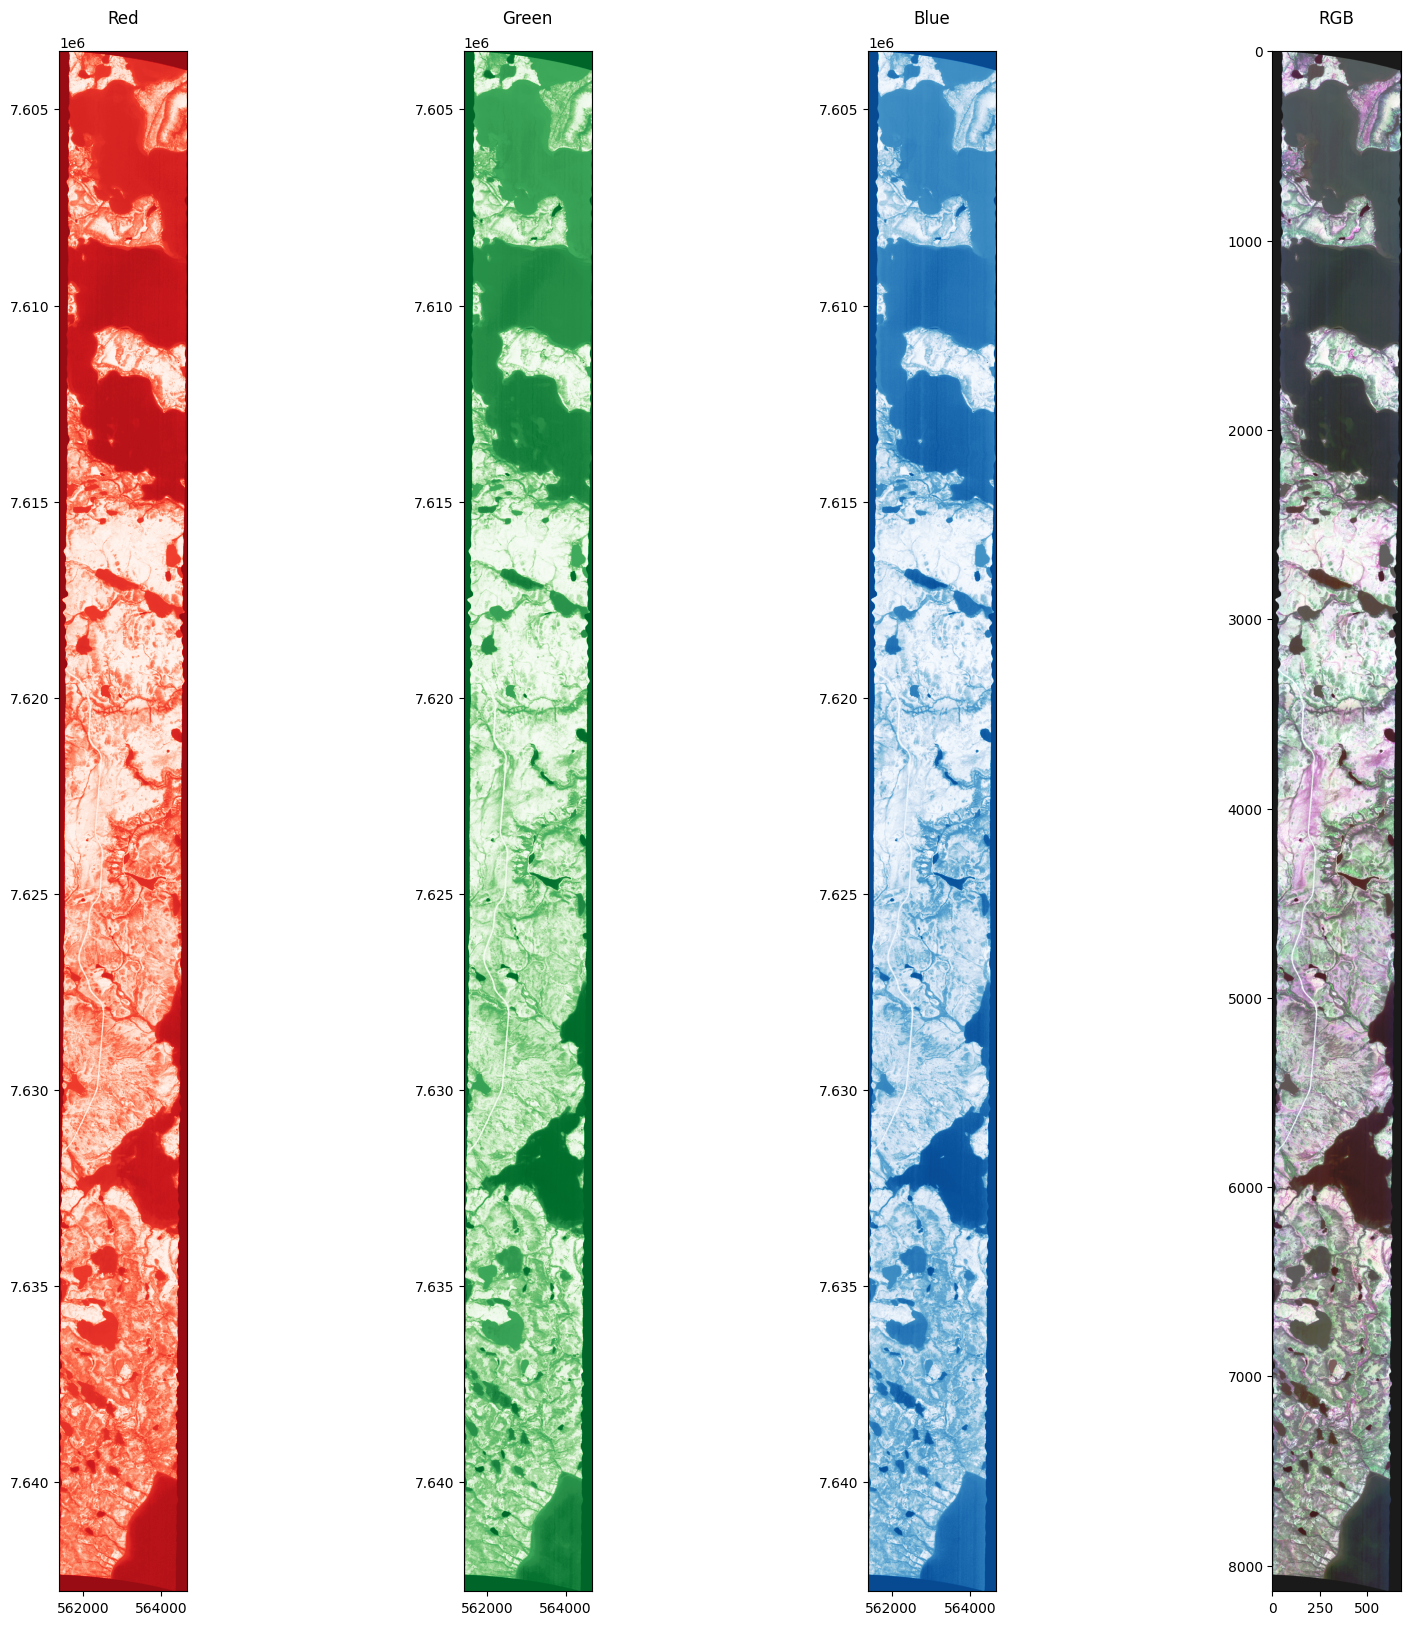

In [10]:
# apply histogram equalization to each band
for i in range(rgb_stack.shape[2]):

    # band i
    b = rgb_stack[:,:,i]
    
    # histogram from flattened (1d) image
    b_histogram, bins = np.histogram(b.flatten(), 256)

    # cumulative distribution function
    b_cumdistfunc = b_histogram.cumsum()

    # normalize
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]

    # get new values by linear interpolation of cdf
    b_equalized = np.interp(b.flatten(), bins[:-1], b_cumdistfunc)
    
    # reshape to 2d and add back to rgb_stack
    rgb_stack[:,:,i] = b_equalized.reshape(b.shape)
    
    
# plot. all of this is matplotlib ---------->
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': rgb_stack[:,:,0], 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': rgb_stack[:,:,1], 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': rgb_stack[:,:,2], 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite_HistEqualized.png", dpi=300, bbox_inches='tight')

plt.imshow(rgb_stack)

# Create Indicies

Band number                  62
Band center (nm)      682.72565
EM region           visible-red
Name: 62, dtype: object
------------------------------------------------------------
Band number                   105
Band center (nm)        898.09565
EM region           near-infrared
Name: 105, dtype: object
------------------------------------------------------------
NDVI stats --- mean: 0.12766881, std: 13.444734, min: -123.469025, max: 21124.125


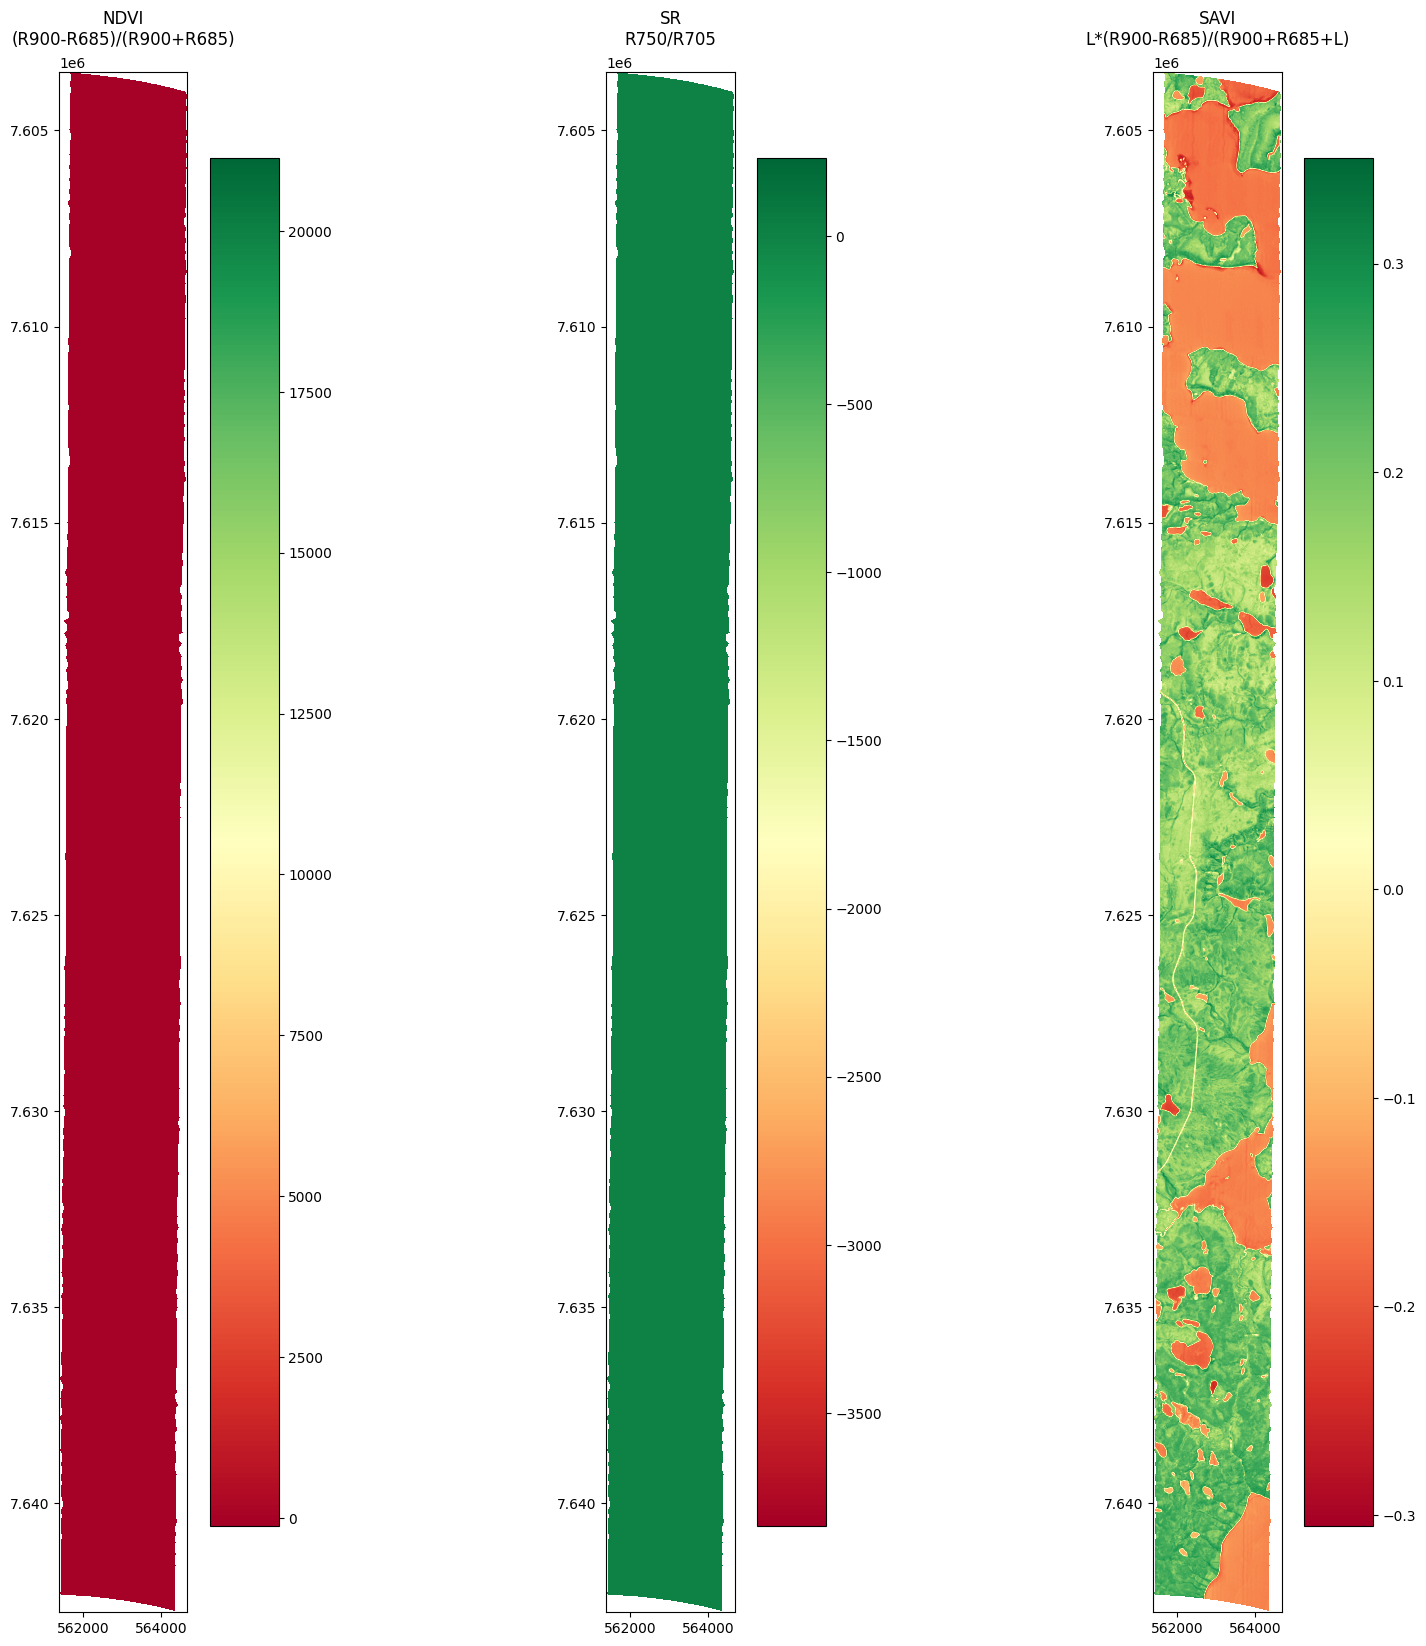

In [11]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))


# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

# calculate NDWI
R860, R1240 = get_band(get_band_number(860)), get_band(get_band_number(1240))
R860[R860 == -9999.], R1240[R1240 == -9999.] = np.nan, np.nan
ndwi_array = (R860-R1240)/(R860+R1240)



# plot. all of this is matplotlib ---------->
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=plt.get_cmap("RdYlGn"),
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    plt.colorbar(p)

# Exporting Spectral Index Arrays to GeoTIFF with GDAL 

In [12]:
# WORKS - this export each single band ratio (NDVI, SR, SAVI) in arrays

# Assuming 'img' is your source raster and the arrays are already computed
arrays = {
    "ndvi": ndvi_array,
    "sr": sr_array,
    "savi": savi_array,
    "ndwi": ndwi_array
}

output_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\"
#file_suffix = "_ang20190728t171711_rdn_v2v2_img.tif" # 2019
#file_suffix = "_ang20170809t232252_rdn_v2p9_img.tif" # 2017
file_suffix = "_ang20220812t220245_rdn_v2aa2_img.tif" # 2022


# Set geotransform and projection from the source image
geo = img.GetGeoTransform()
wkt = img.GetProjection()

for key, array in arrays.items():
    # Replace NaN with no-data value
    array[np.isnan(array)] = -9999.

    # Create the output file path
    output_file = f"{output_path}{key}{file_suffix}"

    # Open GDAL raster dataset for writing
    outraster = gdal.GetDriverByName('GTiff').Create(
        output_file, 
        img.RasterXSize, 
        img.RasterYSize, 
        1, 
        gdal.GDT_Float32
    )

    # Set geotransform and projection
    outraster.SetGeoTransform(geo)
    outraster.SetProjection(wkt)

    # Get the first band and write the array
    outraster_band = outraster.GetRasterBand(1)
    outraster_band.WriteArray(array)
    outraster_band.SetNoDataValue(-9999)

    # Write out and close the file
    outraster.FlushCache()
    outraster = None

print("Done!")


Done!


# CLIP indicies to study site 

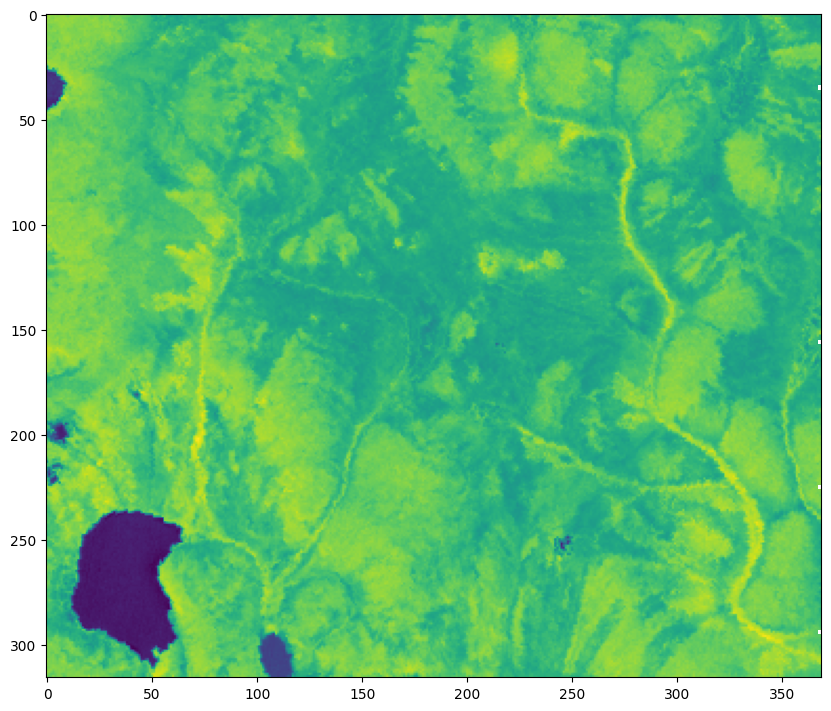

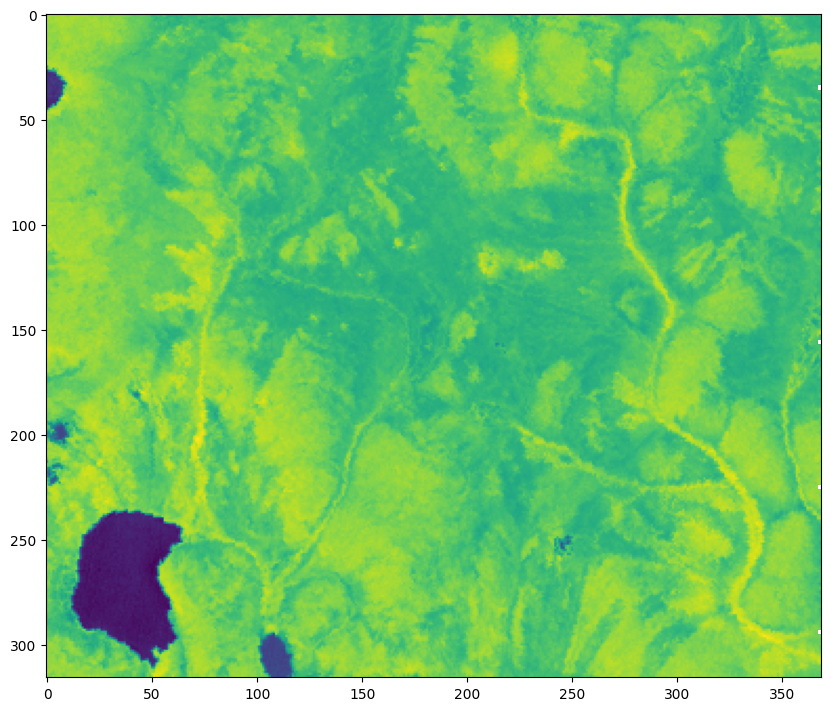

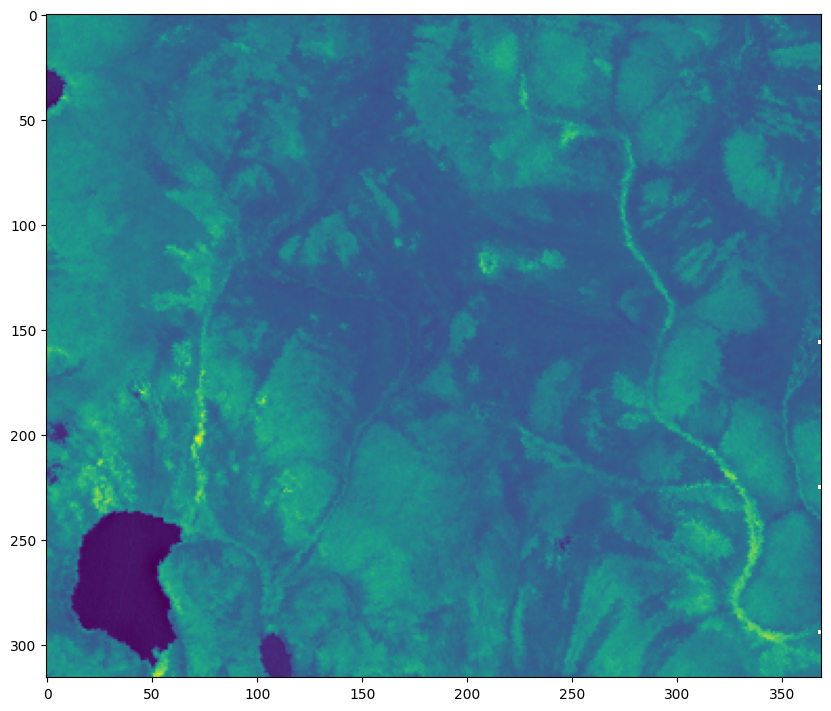

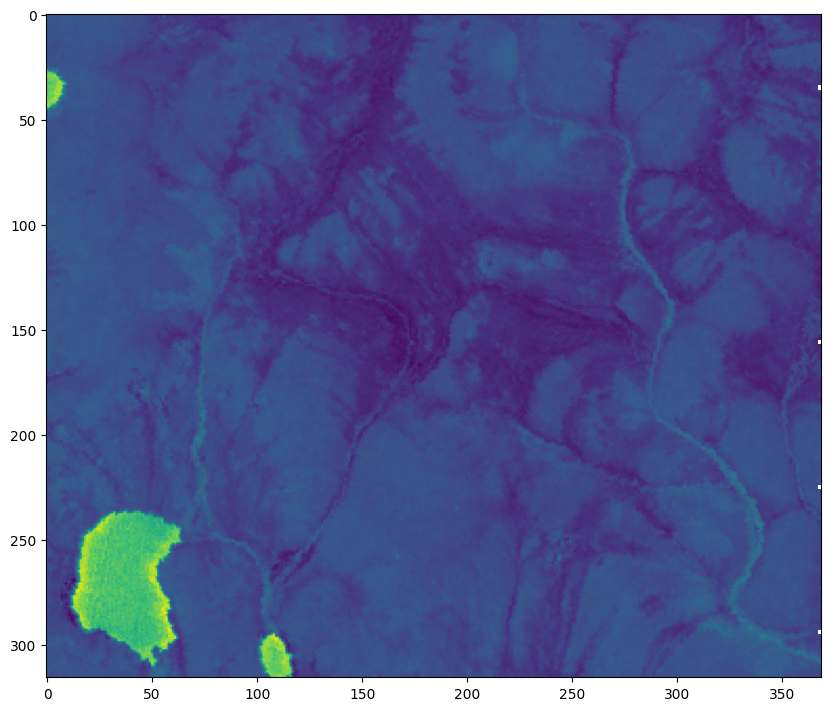

In [13]:
import os
from osgeo import ogr, gdal
import numpy as np
import matplotlib.pyplot as plt

extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(extent)
lyr = shp.GetLayer()

# List of input GeoTIFF files # 2019
# input_files = [
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20190728t171711_rdn_v2v2_img.tif",
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20190728t171711_rdn_v2v2_img.tif",
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20190728t171711_rdn_v2v2_img.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20190728t171711_rdn_v2v2_img.tif"

# ]

# # List of input GeoTIFF files # 2017
# input_files = [
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20170809t232252_rdn_v2p9_img.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20170809t232252_rdn_v2p9_img.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20170809t232252_rdn_v2p9_img.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20170809t232252_rdn_v2p9_img.tif"

# ]

# List of input GeoTIFF files # 2017
input_files = [
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20220812t220245_rdn_v2aa2_img.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20220812t220245_rdn_v2aa2_img.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20220812t220245_rdn_v2aa2_img.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20220812t220245_rdn_v2aa2_img.tif"

]


# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_CLIPPED.tif"

    # Perform clipping
    outraster = gdal.Warp(
        output_file,
        input_file,
        format='GTiff',
        cutlineDSName=extent,
        cutlineLayer=lyr.GetName(),
        cropToCutline=True,
        dstNodata=-9999
    )

    # Plot the clipped image
    plt.rcParams['figure.figsize'] = [10, 10]
    clipped_img = outraster.GetRasterBand(1).ReadAsArray()
    clipped_img[clipped_img == -9999.] = np.nan
    plt.imshow(clipped_img)
    plt.show()


In [ ]:
# to wgs

In [14]:
import os
from osgeo import ogr, gdal, osr
import numpy as np
import matplotlib.pyplot as plt

watershed = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"
extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(watershed)
lyr = shp.GetLayer()

# List of input GeoTIFF files # 2019
# input_files = [
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
#     #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif"

# ]


# # List of input GeoTIFF files # 2017
# input_files = [
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20170809t232252_rdn_v2p9_img_CLIPPED.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20170809t232252_rdn_v2p9_img_CLIPPED.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20170809t232252_rdn_v2p9_img_CLIPPED.tif",
#     "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20170809t232252_rdn_v2p9_img_CLIPPED.tif"
# ]

# List of input GeoTIFF files # 2017
input_files = [
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20220812t220245_rdn_v2aa2_img_CLIPPED.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20220812t220245_rdn_v2aa2_img_CLIPPED.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20220812t220245_rdn_v2aa2_img_CLIPPED.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20220812t220245_rdn_v2aa2_img_CLIPPED.tif"
]



# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_wgs.tif"

    # Open the clipped image
    img = gdal.Open(input_file)

    # Initialize OSR spatial reference object for WGS84
    outsrs = osr.SpatialReference()
    outsrs.ImportFromEPSG(4326)
    
    # Get the projection
    wkt = img.GetProjection()

    # Create virtual warped raster
    warp = gdal.AutoCreateWarpedVRT(
        img,
        wkt,
        outsrs.ExportToWkt(),
        gdal.GRA_NearestNeighbour,
        0.0
    )
    warpb = warp.GetRasterBand(1).ReadAsArray()

    # Create output raster dataset and write warped raster array
    outraster3 = gdal.GetDriverByName('GTiff').Create(
        output_file,
        warp.RasterXSize,
        warp.RasterYSize,
        1,
        gdal.GDT_Float32
    )

    outraster3.SetGeoTransform(warp.GetGeoTransform())
    outraster3.SetProjection(warp.GetProjection())
    outraster3b = outraster3.GetRasterBand(1)
    outraster3b.WriteArray(warpb)
    outraster3b.SetNoDataValue(-9999)
    outraster3.FlushCache()

    # Close open files
    img = None
    outraster3 = None
    warp = None
print("done")

done


# PLOTTING

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt


shpstudysite = r"C:\Users\smdur\OneDrive\Desktop\ABoVE\Shapefile\SquareVegPlots_within_ang20190728t171711.shp"

# Open the raster file
ds = gdal.Open(r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif")
band = ds.GetRasterBand(1)  # Assuming NDWI data is in the first band
ndwi_data = band.ReadAsArray()

# Mask invalid data (e.g., -9999)
ndwi_data = np.ma.masked_where(ndwi_data == -9999, ndwi_data)

gt = ds.GetGeoTransform()
# Create arrays of x and y coordinates in pixel space
x = np.arange(0, ndwi_data.shape[1])
y = np.arange(0, ndwi_data.shape[0])

# Transform the pixel coordinates into geographic coordinates
x_coords = gt[0] + x * gt[1]
y_coords = gt[3] + y * gt[5]

# Make the coordinate arrays 2D to match the NDWI data array
x_coords, y_coords = np.meshgrid(x_coords, y_coords)

# # Plotting the data with actual geographic coordinates
# plt.figure(figsize=(10, 6))
# plt.imshow(ndwi_data, cmap='RdYlGn', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],  vmin=np.min(ndwi_data), vmax=np.max(ndwi_data))
# plt.colorbar(label='NDWI')
# plt.xlabel('UTM Easting (meters)')
# plt.ylabel('UTM Northing (meters)')

# plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\ndwi_plot2d.png', dpi=300)
# plt.show()

# Load the study site shapefile
study_site = gpd.read_file(shpstudysite)

# Plotting the NDWI data
plt.figure(figsize=(10, 6))
plt.imshow(ndwi_data, cmap='RdYlGn', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()], vmin=np.min(ndwi_data), vmax=np.max(ndwi_data))
plt.colorbar(label='SAVI')
plt.xlabel('UTM Easting (meters)')
plt.ylabel('UTM Northing (meters)')

# Plot the study site shapefile on top
study_site.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\savi_plot2d_studysite.png', dpi=300)
plt.show()

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Open the raster file and read the NDWI data
ds = gdal.Open(r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif")
ndwi_data = ds.GetRasterBand(1).ReadAsArray()

# Get geotransform and calculate coordinates
gt = ds.GetGeoTransform()
x = np.arange(ndwi_data.shape[1])
y = np.arange(ndwi_data.shape[0])
x_coords = gt[0] + x * gt[1]
y_coords = gt[3] + y * gt[5]

x_coords, y_coords = np.meshgrid(x_coords, y_coords)

# 3D Surface plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_coords, y_coords, ndwi_data, cmap='RdYlGn', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)

#ax.set_title('NDWI')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('SAVI Value')

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
#ax.grid(False)
ax.view_init(elev=15, azim=-45)
plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\savi_plot3d.png', dpi=300)
plt.show()




# Create FULL stack

In [15]:
import os
from osgeo import ogr, gdal
import matplotlib.pyplot as plt



#dataset = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img")
#dataset = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20170809t232252\\ang20170809t232252_rdn_v2p9\\ang20170809t232252_rdn_v2p9_img")
dataset = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\InputImagery\\ang20220812t220245\\ang20220812t220245_rdn_v2aa2\\ang20220812t220245_rdn_v2aa2_img")


# Path to the shapefile
extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open the shapefile
shp = ogr.Open(extent)
lyr = shp.GetLayer()



# Output file name for the clipped raster
#output_file = os.path.splitext(data_file)[0] + "_CLIPPED_FULL.tif"
#output_file = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20190728t171711_clipped_fullstack2.tif"
#output_file = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20170809t232252_clipped_fullstack.tif"
output_file = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20220812t220245_clipped_fullstack.tif"

print(output_file)


# Perform clipping
outraster = gdal.Warp(
    output_file,
    dataset,
    format='GTiff',
    cutlineDSName=extent,
    cutlineLayer=lyr.GetName(),
    cropToCutline=True,
    dstNodata=-9999
)

# # Assuming you want to display the result
# # Open the clipped raster
# clipped_raster = gdal.Open(output_file)
# band_count = clipped_raster.RasterCount

# # Plotting each band of the clipped image
# plt.rcParams['figure.figsize'] = [10, 10]
# for band in range(1, band_count + 1):
#     band_data = clipped_raster.GetRasterBand(band).ReadAsArray()
#     plt.imshow(band_data)
#     plt.title(f'Band {band}')
#     plt.show()
print("done")

C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20220812t220245_clipped_fullstack.tif
done


# GIF Not Needed

In [ ]:
import rasterio
import imageio

# Path to the TIFF file
tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20190728t171711_clipped_fullstack.tif"

# Open the TIFF file
with rasterio.open(tif_path) as src:
    # Loop through each band
    for i in range(1, src.count + 1):
        # Read the band
        band = src.read(i)
        
        # Normalize the band data to 8-bit (0-255)
        normalized_band = (255 * (band - band.min()) / (band.max() - band.min())).astype('uint8')
        
        # Write the band as an image
        image_path = f"band_{i}.png"
        imageio.imwrite(image_path, normalized_band)
        
# Convert the images to a GIF
images = [imageio.imread(f"band_{i}.png") for i in range(1, src.count + 1)]
gif_path = "bands.gif"
imageio.mimsave(gif_path, images, duration=0.5)

print("GIF created successfully!")


In [18]:
# #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20170809t232252_clipped_fullstack.tif"


# import rasterio
# import pandas as pd
# import numpy as np

# # Path to the TIFF file
# file_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20170809t232252_clipped_fullstack.tif" # 2017

# # Open the TIFF file
# with rasterio.open(file_path) as src:
#     # Read all bands
#     bands = [src.read(i) for i in range(1, src.count + 1)]
#     # Get coordinates
#     transform = src.transform
#     height, width = src.height, src.width
    
#     # Prepare the data for DataFrame
#     data = {
#         f'Band_{i}': band.flatten() for i, band in enumerate(bands, start=1)
#     }

#     # Generate x, y coordinates for each pixel
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     x_coords, y_coords = rasterio.transform.xy(transform, rows, cols, offset='center')
#     data['x'] = np.array(x_coords).flatten()
#     data['y'] = np.array(y_coords).flatten()

#     # Create DataFrame
#     df = pd.DataFrame(data)

# # Display the first few rows of the DataFrame
# print(df.head())

# Define the path for the output text file
output_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\outputtxt\\pixel_values_wLatLong.txt"

# Save the DataFrame as a text file with tab delimiter
df.to_csv(output_path, sep=',', index=False)

print("Data saved to:", output_path)

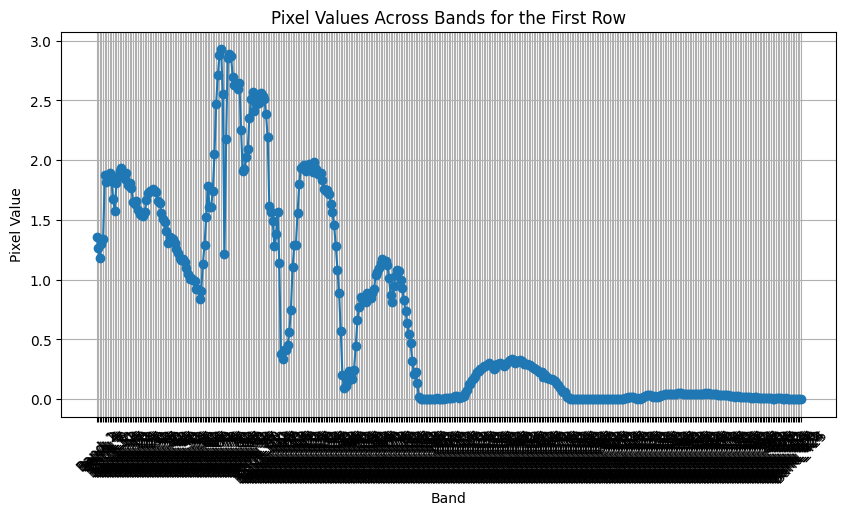

In [5]:
import matplotlib.pyplot as plt

# Extract the first row excluding 'x' and 'y' columns
row_data = df.drop(columns=['x', 'y']).iloc[0]

# Create a plot of the band values
plt.figure(figsize=(10, 5))
plt.plot(row_data.index, row_data.values, marker='o', linestyle='-')
plt.title('Pixel Values Across Bands for the First Row')
plt.xlabel('Band')
plt.ylabel('Pixel Value')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.grid(True)
plt.show()


In [ ]:
# Export band values and lat long points

In [16]:
import rasterio
import pandas as pd
import numpy as np

# Band descriptions dictionary
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# Function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return region

# Path to the TIFF file
#file_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20170809t232252_clipped_fullstack.tif" # 2017
#file_path = r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20190728t171711_clipped_fullstack.tif" # 2019
file_path = r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20220812t220245_clipped_fullstack.tif" #2022


# Open the TIFF file
with rasterio.open(file_path) as src:
    # Read all bands
    bands = [src.read(i) for i in range(1, src.count + 1)]
    
    # Get band centers from metadata, filtering out non-numeric values
    band_centers = []
    for value in src.tags().values():
        try:
            band_centers.append(float(value.split(" ")[0]))
        except ValueError:
            pass
    
    # Get coordinates
    transform = src.transform
    height, width = src.height, src.width
    
    # Prepare the data for DataFrame
    data = {
        f'{band_center} nm': band.flatten() for band, band_center in zip(bands, band_centers)
    }

    # Generate x, y coordinates for each pixel
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    x_coords, y_coords = rasterio.transform.xy(transform, rows, cols, offset='center')
    data['x'] = np.array(x_coords).flatten()
    data['y'] = np.array(y_coords).flatten()

    # Create DataFrame
    df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())


   377.1956495 nm  422.27564950000004 nm  873.0556495000001 nm  \
0        1.423664               1.150302              1.032432   
1        1.396566               1.168048              1.108400   
2        1.476806               1.154717              1.065114   
3        1.440764               1.231584              1.108510   
4        1.380330               1.146838              1.062773   

   878.0656495 nm  883.0756494999999 nm  888.0756494999999 nm  893.0856495 nm  \
0        1.146060              1.267866              1.706835        1.654095   
1        1.190932              1.239527              1.743659        1.660033   
2        1.206456              1.298471              1.718801        1.676817   
3        1.174762              1.206017              1.755816        1.687204   
4        1.173497              1.257373              1.764915        1.679430   

   898.0956495 nm  903.1056495 nm  908.1156495 nm  ...  832.9856495 nm  \
0        1.755690        1.730516        1

In [17]:
# Save DataFrame as a txt file
output_path = r'C:\Users\smdur\OneDrive\Desktop\ABoVE\outputtxt\Pixel_Values_wLatLong_2022.txt'
df.to_csv(output_path, sep='\t', index=False)